# Project Setup

## Please install the following libraries

- !pip install tensorflow

## Project Files
- Please, download the project files from: TBD

## GitHub Link
- GitHub Repository: https://github.com/mlgomez0/advanced_python_project/tree/main/notebooks

## Set the variables

- run_pandas_profiling: equal True means to create the Pandas Profiling which takes time, False means you will use the profile attached with this report

In [1]:
create_pandas_profiling = False
run_models=False

## Please do the following imports

In [2]:
import csv
import pandas as pd
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import chi2_contingency
from wordcloud import WordCloud
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import plotly.express as px
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from ydata_profiling import ProfileReport
from sklearn.svm import SVC
from scipy.stats import randint
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import pickle
import re

d:\Git\advanced_python_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Exploration and Cleaning

For this report, we used posts in Reddit (The code can be found in previous report), a social media platform where people can create communities (subreddits) to discuss several topics. For this report, we focused on communities on climate change and collected those posts that are new and hot in the respective subreddit.

The selected subreddits are: 'climatechange', 'climate_science', 'climate', 'environment', 'GlobalClimateChange', 'climate_change', 'ClimateChangeSurprise'

To gather the dataset, we used the Reddit API. We created a developer account to get the access credentials to work with this API. Additionally, we used a Python package called Prawn ("Python Reddit API Wrapper"). This wrapper facilitates the interactions with the API.

The final dataset has the following features:

- Title: The post title
- Score: It is a net score that equals upvotes minus downvotes for a particular Reddit post
- Author: Author of the post 
- Time: Data of the post
- Comments: Number of comments done to the post
- UpvoteRatio: It is the ratio between upvotes and total votes
- PostId: Unique identifier for the vote
- Subreddit: Name of the subreddit
- is_nsfw: The content is not safe for work
- SelfText: Is the text in the post
- IsSelfText: This boolean tells if the post has self text (In some cases, there is a link or picture instead)
- IsPinned: Refers to whether a post is pinned to a user's profile page
- IsStickied: Indicates the post is pinned to a subreddit
- IsLocked: This boolean indicates if users are able to make new comments on the post
- Sentiment_hf: Sentiment analysis of textual data using Hugging Face (Previous work)
- Sentiment_v: Sentiment analysis of textual data using Vader (Previous work)


In [3]:
df = pd.read_csv('climate_change_sentiment.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15975 entries, 0 to 15974
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         15975 non-null  object 
 1   Score         15975 non-null  int64  
 2   Autor         15518 non-null  object 
 3   Time          15975 non-null  float64
 4   Comments      15975 non-null  int64  
 5   UpvoteRatio   15975 non-null  float64
 6   PostId        15975 non-null  object 
 7   Subreddit     15975 non-null  object 
 8   is_nsfw       15975 non-null  bool   
 9   SelfText      2398 non-null   object 
 10  IsSelfText    15975 non-null  bool   
 11  IsPinned      15975 non-null  bool   
 12  IsStickied    15975 non-null  bool   
 13  IsLocked      15975 non-null  bool   
 14  Sentiment_v   15975 non-null  object 
 15  Sentiment_hf  15975 non-null  object 
dtypes: bool(5), float64(2), int64(2), object(7)
memory usage: 1.4+ MB


Note:

As we can see, the SelfText column has more than 75% null values. Therefore, we'll going to drop that column. Also, the PostId column has just random unique values. Consequently, we will drop that column as well. Finally, 'Sentiment_v' will be removed; we will use 'Sentiment_hf' instead for sentiment.

In [5]:
# Droping columns
df = df.drop(['PostId', 'SelfText', 'Sentiment_v'],axis=1)

In [6]:
# create pandas profiling
if create_pandas_profiling:
    profile = ProfileReport(df, title="Profiling Report")
    profile.to_file("pandas_profiling_ClimateChange2.html")

The pandas report showed the following Alerts:
    
- IsPinned has constant value
- Score is highly overall correlated with Comments
- Subreddit is highly overall correlated with IsSelfText
- IsSelfText is highly overall correlated with Subreddit
- is_nsfw is highly imbalanced (99.4%)
- IsStickied is highly imbalanced (99.4%)
- IsLocked is highly imbalanced (97.9%)
- Autor has 457 (2.9%) missing values
- Score has 278 (1.7%) zeros
- Comments has 3545 (22.2%) zeros

In [7]:
# check the unique values in each columns
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in {column}: {unique_values}")

Unique values in Title: ["I'm afraid climate change is going to kill me! Help!"
 'The r/climatechange Verified User Flair Program'
 'How come some environmentalists are against carbon capture and storage?'
 ... 'Berkeley Lab scientists identify new driver behind Arctic warming'
 'Snowfall less sensitive to warming in Karakoram than in Himalayas due to a unique seasonal cycle'
 'Exposed: Corporate cash is the lifeblood of climate change denial on Capitol Hill']
Unique values in Score: [ 718   30   75 ... 2667 2649 2577]
Unique values in Autor: ['Will_Power' 'technologyisnatural' 'SnooMarzipans7682' ... 'rspix000'
 'madreader121' 'xabby']
Unique values in Time: [1.55010375e+09 1.66111520e+09 1.69798679e+09 ... 1.41548544e+09
 1.41369371e+09 1.41036847e+09]
Unique values in Comments: [ 534   14  296   26   30   34  124    1    2  169  117   19    7  416
   96   57  676    0    9   13    3    5   67   33   93  372  365   16
   43   12   73  315  130   42   88  913  226   21  199   44   11 

In [8]:
# checking nulls in the data
df.isna().sum()

Title             0
Score             0
Autor           457
Time              0
Comments          0
UpvoteRatio       0
Subreddit         0
is_nsfw           0
IsSelfText        0
IsPinned          0
IsStickied        0
IsLocked          0
Sentiment_hf      0
dtype: int64

We remove author as this should not be a predictor for the model, we don't want the model to learn about the author of the posts as the tool is meant to be used by any author.

In [9]:
df.drop('Autor', axis=1, inplace=True)

We remove UpvoteRatio and Comments as this columns have information that the user of the model won't have to make a prediction.

In [10]:
df.drop('UpvoteRatio', axis=1, inplace=True)
df.drop('Comments', axis=1, inplace=True)

In [11]:
# With this, the data has no nulls
df.isna().sum()

Title           0
Score           0
Time            0
Subreddit       0
is_nsfw         0
IsSelfText      0
IsPinned        0
IsStickied      0
IsLocked        0
Sentiment_hf    0
dtype: int64

In [12]:
# Creating Categorical Score
df['Score_cat'], bin_edges = pd.qcut(df['Score'], q=4, labels=False, retbins=True)

Text(0, 0.5, 'Frequency')

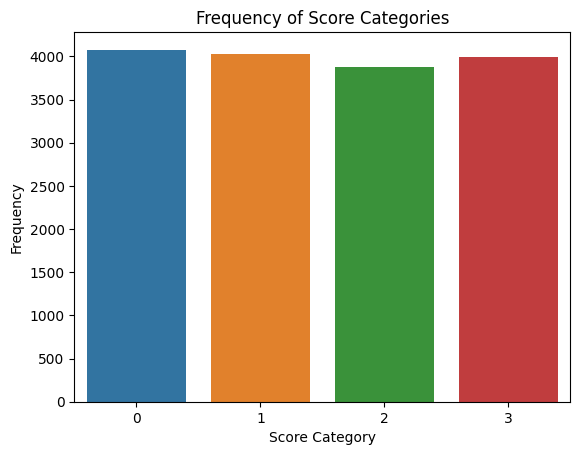

In [13]:
# Plot of Score Categories
sns.countplot(data=df, x='Score_cat')
sns.color_palette("pastel")
plt.title("Frequency of Score Categories")
plt.xlabel("Score Category")
plt.ylabel("Frequency")

As can be seen the categories are balanced

In [14]:
# eliminate Score
df.drop("Score", axis=1, inplace=True)

In [15]:
df.head()

,Title,Time,Subreddit,is_nsfw,IsSelfText,IsPinned,IsStickied,IsLocked,Sentiment_hf,Score_cat
0,I'm afraid climate change is going to kill me!...,1.550104e+09,climatechange,False,True,False,True,False,negative,3
1,The r/climatechange Verified User Flair Program,1.661115e+09,climatechange,False,True,False,True,False,positive,2
2,How come some environmentalists are against ca...,1.697987e+09,climatechange,False,True,False,False,False,negative,2
3,Solar and wind are better than nuclear,1.698006e+09,climatechange,False,True,False,False,False,positive,1
4,When will we hit 2 degrees of global warming?,1.698013e+09,climatechange,False,True,False,False,False,negative,0


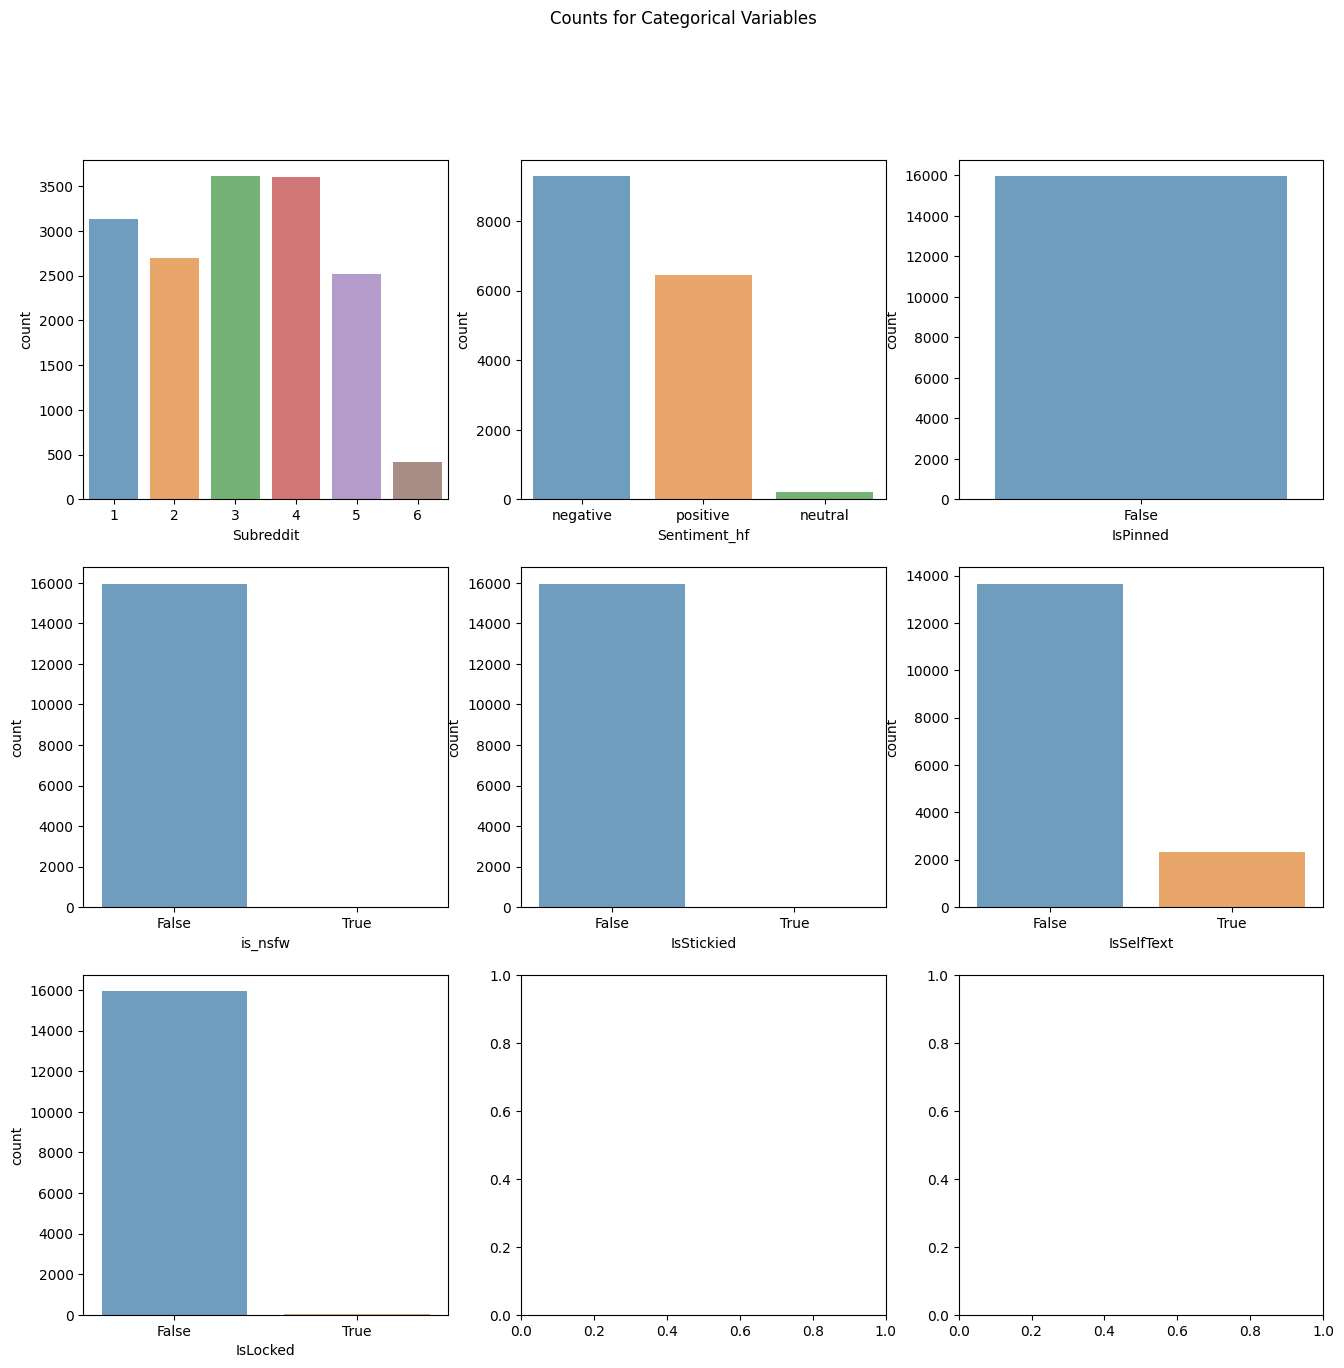

In [16]:
# checking all categorical columns

fig, axes = plt.subplots(3, 3, figsize=(16, 15))

sns.countplot(ax=axes[0][0], data=df, x='Subreddit', alpha=0.7)
axes[0][0].set_xticklabels([1, 2, 3, 4, 5, 6])
sns.countplot(ax=axes[0][1], data=df, x='Sentiment_hf', alpha=0.7)
sns.countplot(ax=axes[0][2], data=df, x='IsPinned', alpha=0.7)
sns.countplot(ax=axes[1][0], data=df, x='is_nsfw', alpha=0.7)
sns.countplot(ax=axes[1][1], data=df, x='IsStickied', alpha=0.7)
sns.countplot(ax=axes[1][2], data=df, x='IsSelfText', alpha=0.7)
sns.countplot(ax=axes[2][0], data=df, x='IsLocked', alpha=0.7)
sns.color_palette("pastel")
fig.suptitle("Counts for Categorical Variables")

plt.show()

As can be seen in the graph above, there are many categorical values with the same value for all the records or highly imbalance. Therefore, we will remove those columns.

In [17]:
df.drop(['IsPinned', 'is_nsfw', 'IsStickied', 'IsLocked'], axis=1, inplace=True)

In [18]:
df.head()

,Title,Time,Subreddit,IsSelfText,Sentiment_hf,Score_cat
0,I'm afraid climate change is going to kill me!...,1.550104e+09,climatechange,True,negative,3
1,The r/climatechange Verified User Flair Program,1.661115e+09,climatechange,True,positive,2
2,How come some environmentalists are against ca...,1.697987e+09,climatechange,True,negative,2
3,Solar and wind are better than nuclear,1.698006e+09,climatechange,True,positive,1
4,When will we hit 2 degrees of global warming?,1.698013e+09,climatechange,True,negative,0


## Time column

In [19]:
# Now cleaning the Time column's data
df['Time'] = pd.to_datetime(df['Time'], unit='s')

df['Year'] = df['Time'].dt.year
df['Month'] = df['Time'].dt.month
df['Day'] = df['Time'].dt.day
df['Hour'] = df['Time'].dt.hour

# Feature enginering two new columns

df['TimeOfDay'] = pd.cut(df['Time'].dt.hour, bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

df['IsWeekend'] = df['Time'].dt.weekday // 5 == 1

In [20]:
df.drop(columns=['Time'], inplace=True)

In [21]:
#check again nulls
df.isna().sum()

Title             0
Subreddit         0
IsSelfText        0
Sentiment_hf      0
Score_cat         0
Year              0
Month             0
Day               0
Hour              0
TimeOfDay       570
IsWeekend         0
dtype: int64

In [22]:
#Imputing nulls in new created column TimeOfDay
df['TimeOfDay'].fillna(df['TimeOfDay'].mode().iloc[0], inplace=True)

In [23]:
# checking back nulls
df.isna().sum()

Title           0
Subreddit       0
IsSelfText      0
Sentiment_hf    0
Score_cat       0
Year            0
Month           0
Day             0
Hour            0
TimeOfDay       0
IsWeekend       0
dtype: int64

d:\Git\advanced_python_project\.venv\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


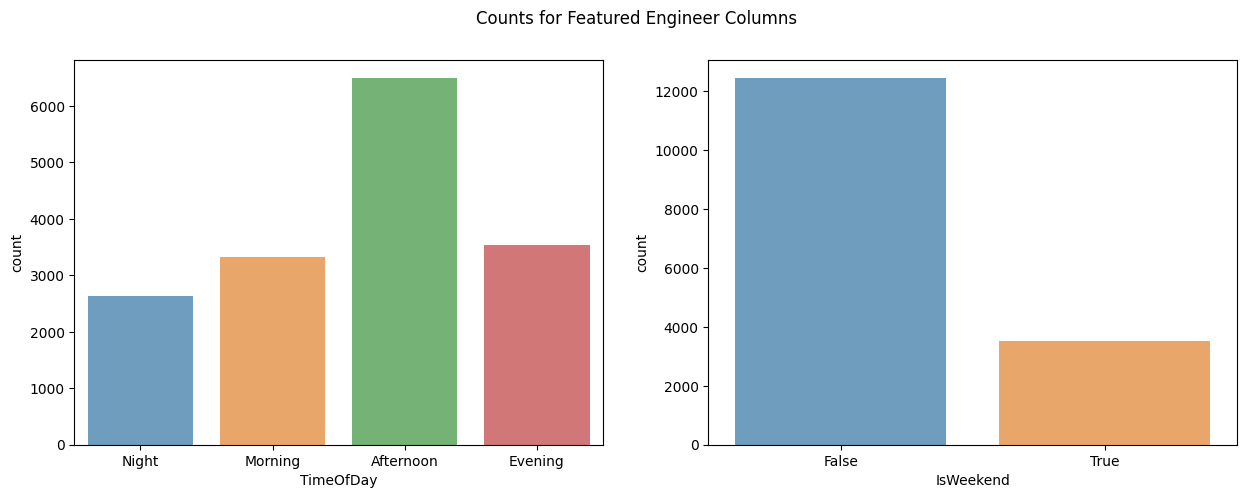

In [24]:
# Checking new categorical columns

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(ax=axes[0], data=df, x='TimeOfDay', alpha=0.7)
sns.countplot(ax=axes[1], data=df, x='IsWeekend', alpha=0.7)
sns.color_palette("pastel")

fig.suptitle("Counts for Featured Engineer Columns")

plt.show()

In [25]:
df.head()

,Title,Subreddit,IsSelfText,Sentiment_hf,Score_cat,Year,Month,Day,Hour,TimeOfDay,IsWeekend
0,I'm afraid climate change is going to kill me!...,climatechange,True,negative,3,2019,2,14,0,Afternoon,False
1,The r/climatechange Verified User Flair Program,climatechange,True,positive,2,2022,8,21,20,Evening,True
2,How come some environmentalists are against ca...,climatechange,True,negative,2,2023,10,22,14,Afternoon,True
3,Solar and wind are better than nuclear,climatechange,True,positive,1,2023,10,22,20,Evening,True
4,When will we hit 2 degrees of global warming?,climatechange,True,negative,0,2023,10,22,22,Evening,True


# Feature Extraction and Scaling

In [26]:
# spliting data before doing transformations to avoid data leakage

Y_df = df['Score_cat']
X_df = df.drop('Score_cat', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_df, Y_df, test_size=0.2, random_state=42)

In [27]:
# function to process textual data
def preprocess_textual_data(data, text_column='Title'):
    """
    Preprocesses text data and returns a TF-IDF matrix.
    """
    corpus = []
    for i in range(len(data)):
        text = re.sub(r'\W', ' ', str(data[text_column].iloc[i]))
        text = text.lower()
        text = re.sub(r'^br$', ' ', text)
        text = re.sub(r'\s+br\s+',' ', text)
        text = re.sub(r'\s+[a-z]\s+', ' ', text)
        text = re.sub(r'^b\s+', '', text)
        text = re.sub(r'\s+', ' ', text)
        corpus.append(text)
    return corpus

In [28]:
# vectorizing textual data (Title) with TF-IDF
clean_x_train = preprocess_textual_data(X_train)
clean_x_test = preprocess_textual_data(X_test)
vectorizer = TfidfVectorizer(max_features=1000, min_df=3, max_df=0.6, stop_words=stopwords.words('english'))
tfidf = vectorizer.fit(clean_x_train)
tfidf_X_train = tfidf.transform(clean_x_train).toarray()
tfidf_X_test = tfidf.transform(clean_x_test).toarray()

In [29]:
# Creating a DataFrame with the vectorized text
df_text_tfidf_train = pd.DataFrame(tfidf_X_train, columns=tfidf.get_feature_names_out())
df_text_tfidf_test = pd.DataFrame(tfidf_X_test, columns=tfidf.get_feature_names_out())

In [30]:
# Pipeline to transform features

cat_nominal = ['Subreddit']
cat_ordinal = ['Sentiment_hf', 'TimeOfDay']
cat_binary = ['IsWeekend', 'IsSelfText']

numerical_cols = ['Year', 'Month', 'Day', 'Hour']

def preprocess_and_vectorize_titles(data):
    return preprocess_and_vectorize(data, text_column='Title')


pipeline_cat_nomical = Pipeline(steps=[
    ('one-hot', OneHotEncoder())
])

pipeline_cat_binary = Pipeline(steps=[
    ('one-hot', OneHotEncoder(drop='if_binary'))
])


pipeline_cat_ordinal = Pipeline(steps=[
      ('ord', OrdinalEncoder())
])


preprocessor = ColumnTransformer(transformers=[
    ('nom', pipeline_cat_nomical, cat_nominal),
    ('ord', pipeline_cat_ordinal, cat_ordinal),
    ('binary', pipeline_cat_binary, cat_binary),
    ('passthrough', 'passthrough', numerical_cols)
])

# Transformed no textual columns
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [31]:
# Print the transformed shapes
print(f"X_train_transformed.shape: {X_train.shape}")
print(f"X_test_transformed.shape: {X_test.shape}")

X_train_transformed.shape: (12780, 14)
X_test_transformed.shape: (3195, 14)


In [32]:
features = preprocessor.get_feature_names_out()

In [33]:
# create data frames without textual data
df_train = pd.DataFrame(X_train, columns=features)
df_test = pd.DataFrame(X_test, columns=features)

print(f"No textual df.shape: {df_train.shape}")
print(f"No textual df.shape: {df_test.shape}")

No textual df.shape: (12780, 14)
No textual df.shape: (3195, 14)


In [34]:
# concatenate the transformed dataframes
X_final_train = pd.concat([df_train, df_text_tfidf_train], axis=1)
X_final_test = pd.concat([df_test, df_text_tfidf_test], axis=1)

# Modeling

In [35]:
# Funtion to plot confusion matrix
def confusion_matrix_graph(y, y_pred, label):
    cm_decision_tree_classifier = confusion_matrix(y, y_pred)
    cm_df = pd.DataFrame(cm_decision_tree_classifier, index=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'], columns=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'])
    sns.heatmap(cm_df, annot=True, cmap='Blues', cbar=False, )
    plt.title(f"Confusion matrix for {label}")
    
#Function to save the trained model
def save_model_pickle(file_name, model):
    file_name = file_name + '.pkl'
    with open(file_name, 'wb') as file:
        pickle.dump(model, file)

#Function to retrieve the trained model
def retrieve_model_pickle(file_name):
    file_name = file_name + '.pkl'
    with open(file_name, 'rb') as file:
        model = pickle.load(file)
        return model
    
# Function to extract feature importance

def get_top_features(model, df, num): 
    important_features = model.feature_importances_
    top_indices = np.argsort(important_features)[-num:][::-1]
    top_features = df.columns[top_indices]
    print(f'The {num} most important features are: {list(top_features)}')
    
# function to print metrics
def print_metrics(y_test, y_pred, label):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print evaluation metrics
    print(f"Accuracy for {label}: {accuracy}")
    print(f"Precision for {label}: {precision}")
    print(f"Recall for {label}: {recall}")
    print(f"F1-score for {label}: {f1}")
    return accuracy, precision, recall, f1

In [36]:
# Setting up a dataframe to store the results
df_models_explorations = pd.DataFrame({
    "model": ["SVM", "XGBoost", "AdaBoost", "Decision Tree", "GB"],
    "accuracy_test": [0, 0, 0, 0, 0],
    "accuracy_train": [0, 0, 0, 0, 0],
    "precision_test": [0, 0, 0, 0, 0],
    "precision_train": [0, 0, 0, 0, 0],
    "recall_test": [0, 0, 0, 0, 0],
    "recall_train": [0, 0, 0, 0, 0],
    "F1_test": [0, 0, 0, 0, 0],
    "F1_test": [0, 0, 0, 0, 0]
})
df_models_explorations.set_index('model', inplace=True)
df_models_explorations

,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,F1_test
model,,,,,,,
SVM,0,0,0,0,0,0,0
XGBoost,0,0,0,0,0,0,0
AdaBoost,0,0,0,0,0,0,0
Decision Tree,0,0,0,0,0,0,0
GB,0,0,0,0,0,0,0


## Gradient Boosting Classifier

In [37]:
if run_models:
    gb_clf = GradientBoostingClassifier(learning_rate=0.1)
    gb_clf.fit(X_final_train, y_train)
    save_model_pickle('gb_clf', gb_clf)
else:
    gb_clf = retrieve_model_pickle('gb_clf')


y_pred_test = gb_clf.predict(X_final_test)
y_pred_train = gb_clf.predict(X_final_train)

# metrics test set
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_pred_test, "Test")
df_models_explorations.loc['GB', 'accuracy_test'] = accuracy_te
df_models_explorations.loc['GB', 'precision_test'] = precision_te
df_models_explorations.loc['GB', 'recall_test'] = recall_te
df_models_explorations.loc['GB', 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_pred_train, "Train")
df_models_explorations.loc['GB', 'accuracy_train'] = accuracy_tr
df_models_explorations.loc['GB', 'precision_train'] = precision_tr
df_models_explorations.loc['GB', 'recall_train'] = recall_tr
df_models_explorations.loc['GB', 'F1_train'] = f1_tr

Accuracy for Test: 0.6181533646322379
Precision for Test: 0.6210346060727117
Recall for Test: 0.6181533646322379
F1-score for Test: 0.6148819210999183
---------------------------------
Accuracy for Train: 0.6751956181533646
Precision for Train: 0.6815245688846313
Recall for Train: 0.6751956181533646
F1-score for Train: 0.6732639509696047


C:\Users\acorr\AppData\Local\Temp\ipykernel_6148\1722816445.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6181533646322379' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_models_explorations.loc['GB', 'accuracy_test'] = accuracy_te
C:\Users\acorr\AppData\Local\Temp\ipykernel_6148\1722816445.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6210346060727117' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_models_explorations.loc['GB', 'precision_test'] = precision_te
C:\Users\acorr\AppData\Local\Temp\ipykernel_6148\1722816445.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6181533646322379' has dtype incompatible with int64, please explicitly cast to a compatible dty

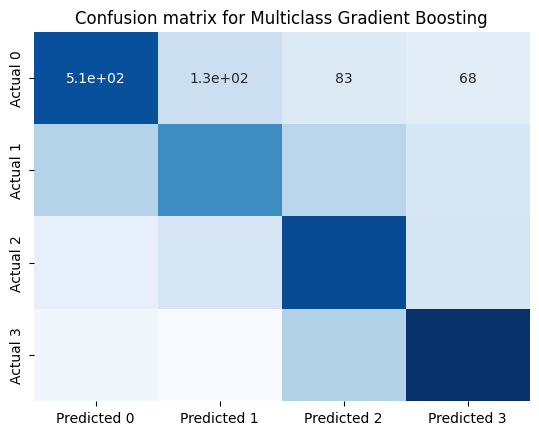

In [38]:
confusion_matrix_graph(y_test, y_pred_test, "Multiclass Gradient Boosting")

## Support Vector Machine

In [39]:
# train multiclass SVC
if run_models:
    svc_clf = SVC(probability=True, random_state=42, decision_function_shape='ovo')
    svc_clf.fit(X_final_train, y_train)
    save_model_pickle('SVM1', svc_clf)
else:
    svc_clf = retrieve_model_pickle('SVM1')

y_pred_test = svc_clf.predict(X_final_test)
y_pred_train = svc_clf.predict(X_final_train)

# metrics test set
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_pred_test, "Test")
df_models_explorations.loc['SVM', 'accuracy_test'] = accuracy_te
df_models_explorations.loc['SVM', 'precision_test'] = precision_te
df_models_explorations.loc['SVM', 'recall_test'] = recall_te
df_models_explorations.loc['SVM', 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_pred_train, "Train")
df_models_explorations.loc['SVM', 'accuracy_train'] = accuracy_tr
df_models_explorations.loc['SVM', 'precision_train'] = precision_tr
df_models_explorations.loc['SVM', 'recall_train'] = recall_tr
df_models_explorations.loc['SVM', 'F1_train'] = f1_tr

d:\Git\advanced_python_project\.venv\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.2.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Accuracy for Test: 0.24726134585289514
Precision for Test: 0.061138173152985024
Recall for Test: 0.24726134585289514
F1-score for Test: 0.09803586610980534
---------------------------------
Accuracy for Train: 0.25727699530516435
Precision for Train: 0.06619145231325356
Recall for Train: 0.25727699530516435
F1-score for Train: 0.10529334833997764


d:\Git\advanced_python_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Git\advanced_python_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


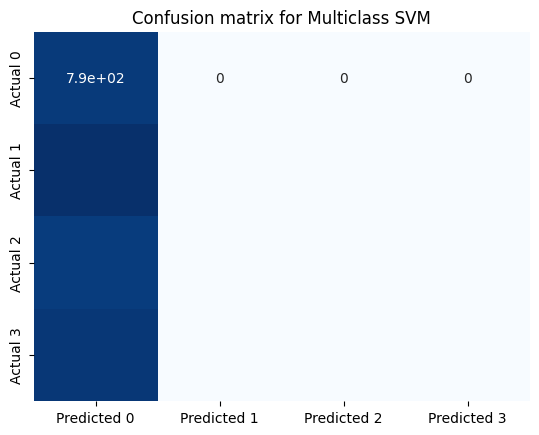

In [40]:
confusion_matrix_graph(y_test, y_pred_test, "Multiclass SVM")

As can be see, the model predicted all categories as 0.

## XGBoost Classifier

In [41]:
if run_models:
    xgb_clf = xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=50,
        max_depth=3,
        subsample=1.0,
        colsample_bytree=1.0,
        random_state=42
    )
    xgb_clf.fit(X_final_train, y_train)
    save_model_pickle('xgb_clf', xgb_clf)
else:
    xgb_clf = retrieve_model_pickle('xgb_clf')


y_pred_test = xgb_clf.predict(X_final_test)
y_pred_train = xgb_clf.predict(X_final_train)

# metrics test set
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_pred_test, "Test")
df_models_explorations.loc['XGBoost', 'accuracy_test'] = accuracy_te
df_models_explorations.loc['XGBoost', 'precision_test'] = precision_te
df_models_explorations.loc['XGBoost', 'recall_test'] = recall_te
df_models_explorations.loc['XGBoost', 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_pred_train, "Train")
df_models_explorations.loc['XGBoost', 'accuracy_train'] = accuracy_tr
df_models_explorations.loc['XGBoost', 'precision_train'] = precision_tr
df_models_explorations.loc['XGBoost', 'recall_train'] = recall_tr
df_models_explorations.loc['XGBoost', 'F1_train'] = f1_tr

Accuracy for Test: 0.5483568075117371
Precision for Test: 0.558769017426821
Recall for Test: 0.5483568075117371
F1-score for Test: 0.5449688631768526
---------------------------------
Accuracy for Train: 0.5619718309859155
Precision for Train: 0.5779450339467455
Recall for Train: 0.5619718309859155
F1-score for Train: 0.5592137696246354


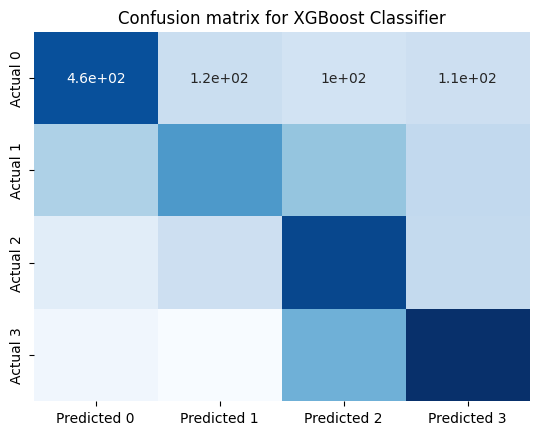

In [42]:
confusion_matrix_graph(y_test, y_pred_test, "XGBoost Classifier")

## Ada Boost Classifier

In [43]:
# Create the AdaBoostClassifier
if run_models:
    ada_clf = AdaBoostClassifier(
        n_estimators=100,
        learning_rate=1.0,
        random_state=42
    )

    ada_clf.fit(X_final_train, y_train)
    save_model_pickle('ada_clf', ada_clf)
else:
    ada_clf = retrieve_model_pickle('ada_clf')


y_pred_test = ada_clf.predict(X_final_test)
y_pred_train = ada_clf.predict(X_final_train)

# metrics test set
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_pred_test, "Test")
df_models_explorations.loc["AdaBoost", 'accuracy_test'] = accuracy_te
df_models_explorations.loc["AdaBoost", 'precision_test'] = precision_te
df_models_explorations.loc["AdaBoost", 'recall_test'] = recall_te
df_models_explorations.loc["AdaBoost", 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_pred_train, "Train")
df_models_explorations.loc["AdaBoost", 'accuracy_train'] = accuracy_tr
df_models_explorations.loc["AdaBoost", 'precision_train'] = precision_tr
df_models_explorations.loc["AdaBoost", 'recall_train'] = recall_tr
df_models_explorations.loc["AdaBoost", 'F1_train'] = f1_tr

d:\Git\advanced_python_project\.venv\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ValueError: node array from the pickle has an incompatible dtype:
- expected: {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}
- got     : [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]

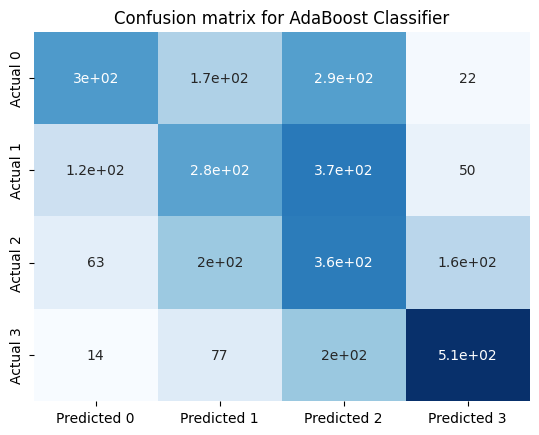

In [ ]:
confusion_matrix_graph(y_test, y_pred_test, "AdaBoost Classifier")

## Decision Tree Classifier

In [ ]:
if run_models:
    dt_clf = DecisionTreeClassifier(random_state=42)
    dt_clf.fit(X_final_train, y_train)
    save_model_pickle('dt_clf', dt_clf)
else:
    dt_clf = retrieve_model_pickle('dt_clf')

y_pred_test = dt_clf.predict(X_final_test)
y_pred_train = dt_clf.predict(X_final_train)

# metrics test set
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_pred_test, "Test")
df_models_explorations.loc["Decision Tree", 'accuracy_test'] = accuracy_te
df_models_explorations.loc["Decision Tree", 'precision_test'] = precision_te
df_models_explorations.loc["Decision Tree", 'recall_test'] = recall_te
df_models_explorations.loc["Decision Tree", 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_pred_train, "Train")
df_models_explorations.loc["Decision Tree", 'accuracy_train'] = accuracy_tr
df_models_explorations.loc["Decision Tree", 'precision_train'] = precision_tr
df_models_explorations.loc["Decision Tree", 'recall_train'] = recall_tr
df_models_explorations.loc["Decision Tree", 'F1_train'] = f1_tr

Accuracy for Test: 0.8194053208137715
Precision for Test: 0.8196817495298493
Recall for Test: 0.8194053208137715
F1-score for Test: 0.819467594739577
---------------------------------
Accuracy for Train: 0.9842723004694836
Precision for Train: 0.9843489273492083
Recall for Train: 0.9842723004694836
F1-score for Train: 0.9842687125335944


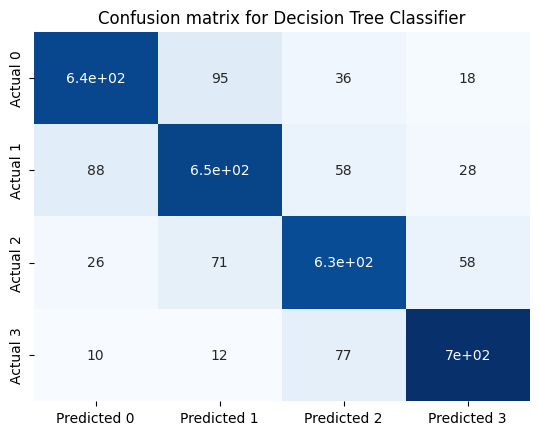

In [ ]:
confusion_matrix_graph(y_test, y_pred_test, "Decision Tree Classifier")

## Model Exploration Results

In [ ]:
df_models_explorations.sort_values('accuracy_test', ascending=False)

,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,F1_test,F1_train
model,,,,,,,,
Decision Tree,0.819405,0.984272,0.819682,0.984349,0.819405,0.984272,0.819468,0.984269
GB,0.617840,0.673709,0.620368,0.679793,0.617840,0.673709,0.614771,0.671664
XGBoost,0.548357,0.561972,0.558769,0.577945,0.548357,0.561972,0.544969,0.559214
AdaBoost,0.455712,0.487793,0.494946,0.529305,0.455712,0.487793,0.463925,0.494818
SVM,0.247261,0.257277,0.061138,0.066191,0.247261,0.257277,0.098036,0.105293


As can be seen the best models to move forward with optimization are Decision Tree Classifier and Gradient Boosting Classifier. The first one is overfitting more than the second one.

## Model Optimization

### Randomized Search

#### Gradient Boosting Classifier

In [ ]:
# Randomized Search, Iteration 1

param_dist = {
        'n_estimators': [ 32, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [1, 3, 5, 10],
        'min_samples_split': [1, 2, 5],
        'min_samples_leaf': [1, 2],
        'subsample': [0.8, 0.9, 1.0]
}
if run_models:
    gb_clf_rs = GradientBoostingClassifier()

    # Create RandomizedSearchCV
    random_search = RandomizedSearchCV(gb_clf_rs, param_distributions=param_dist, n_iter=10,
                                       scoring='accuracy', cv=5, random_state=42)

    # Fit the model
    random_search.fit(X_final_train, y_train)
    best_params = random_search.best_params_

    # Print the best parameters
    print("Best Parameters:", best_params)

    # get the best estimator
    best_estimator = random_search.best_estimator_
    save_model_pickle('gb_clf_rs_be', best_estimator)
else:
    best_estimator = retrieve_model_pickle('gb_clf_rs_be')


KeyboardInterrupt: 

In [ ]:
y_pred_test =  best_estimator.predict(X_final_test)
y_pred_train =  best_estimator.predict(X_final_train)

# metrics test set
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_pred_test, "Test")

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_pred_train, "Train")


In [ ]:
# Iteration 2 using best parameters with early stoping

gb_clf_es = GradientBoostingClassifier(
                                        subsample=0.8,
                                        n_estimators=200,
                                        min_samples_split=5,
                                        min_samples_leaf=2,
                                        max_depth=10,
                                        learning_rate=0.1,
                                        n_iter_no_change=5,
                                        validation_fraction=0.2,
                                        tol=0.001)
gb_clf_es.fit(X_final_train, y_train)
y_pred_test =  gb_clf_es.predict(X_final_test)
y_pred_train =  gb_clf_es.predict(X_final_train)

# metrics test set
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_pred_test, "Test")

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_pred_train, "Train")



Accuracy for Test: 0.7715179968701096
Precision for Test: 0.7741416971585128
Recall for Test: 0.7715179968701096
F1-score for Test: 0.7722820462510969
---------------------------------
Accuracy for Train: 0.923943661971831
Precision for Train: 0.9242509891077811
Recall for Train: 0.923943661971831
F1-score for Train: 0.9239556471552921


In [ ]:
save_model_pickle('gb_clf_es', gb_clf_es)

In [ ]:
# Randomized Search, Iteration 3

param_dist = {
        'n_estimators': [ 32, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5], # reduce complexity
        'min_samples_split': [5, 10], # more regularization
        'min_samples_leaf': [2, 5], # more regularization
        'subsample': [0.5, 0.6,0.8]
}
if run_models:
    gb_clf_rs_1 = GradientBoostingClassifier()

    # Create RandomizedSearchCV
    random_search = RandomizedSearchCV(gb_clf_rs_1, param_distributions=param_dist, n_iter=10,
                                       scoring='accuracy', cv=5, random_state=42, n_jobs=-1)

    # Fit the model
    random_search.fit(X_final_train, y_train)
    best_params = random_search.best_params_

    # Print the best parameters
    print("Best Parameters:", best_params)

    # get the best estimator
    best_estimator = random_search.best_estimator_
    save_model_pickle('gb_clf_rs_be_1', best_estimator)
else:
    best_estimator = retrieve_model_pickle('gb_clf_rs_be_1')


Best Parameters: {'subsample': 0.6, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 5, 'learning_rate': 0.1}


In [ ]:
y_pred_test =  best_estimator.predict(X_final_test)
y_pred_train =  best_estimator.predict(X_final_train)

# metrics test set
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_pred_test, "Test")

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_pred_train, "Train")

Accuracy for Test: 0.7098591549295775
Precision for Test: 0.7140619575490754
Recall for Test: 0.7098591549295775
F1-score for Test: 0.7105500871635345
---------------------------------
Accuracy for Train: 0.8416275430359937
Precision for Train: 0.8440321730626444
Recall for Train: 0.8416275430359937
F1-score for Train: 0.841798908795308


In [ ]:
from sklearn.feature_selection import RFECV

class ModelMetrics():

    def __init__(self, y_real, y_pred) -> None:
        self.accuracy = accuracy_score(y_real, y_pred)
        self.precision = precision_score(y_real, y_pred, average='weighted')
        self.recall = recall_score(y_real, y_pred, average='weighted')
        self.f1 = f1_score(y_real, y_pred, average='weighted')

class RFECVResult():

    def __init__(self, rfecv: RFECV, X_train, y_train, X_test, y_test):
        self._rfecv = rfecv
        self._model = rfecv.estimator_
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    @property
    def rfecv(self):
        return self._rfecv
    
    @property
    def model(self):
        return self._model
    
    @property
    def train_metricts(self) -> ModelMetrics:
        return self._train_metricts
    
    @property
    def test_metricts(self) -> ModelMetrics:
        return self._test_metricts
    
    def execute(self):
        
        # Transform train and test
        self.X_train_transformed = self.rfecv.transform(self.X_train)
        self.X_test_transformed = self.rfecv.transform(self.X_test)

        # Predict on train and test
        self.y_pred_train = self.model.predict(self.X_train_transformed)
        self.y_pred_test = self.model.predict(self.X_test_transformed)

        # Calculate metrics
        self._train_metricts = ModelMetrics(y_train, y_pred_train)
        self._test_metricts = ModelMetrics(y_test, y_pred_test)


In [ ]:
def execute_rfe(estimator, min_features_to_select: int):

    # Get the data to train the model
    X_train  = X_final_train
    X_test = X_final_test

    # Create the RFE object and compute a cross-validated score.
    print(f"Running RFECV with estimator {type(estimator)}")
    rfecv = RFECV(estimator=estimator, min_features_to_select=min_features_to_select, step=1, n_jobs=-1, cv=5, scoring='accuracy', verbose=1)
    rfecv.fit(X_train, y_train)
    print(f"Optimal number of features : {rfecv.n_features_}")
    
    # Create the model data object
    result = RFECVResult(rfecv=rfecv, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    result.execute()

    return result


In [ ]:
if run_models:
    decision_tree_rfecv = execute_rfe(dt_clf, 500)

Running RFECV with estimator <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Fitting estimator with 1014 features.
Fitting estimator with 1013 features.
Fitting estimator with 1012 features.
Fitting estimator with 1011 features.
Fitting estimator with 1010 features.
Fitting estimator with 1009 features.
Fitting estimator with 1008 features.
Fitting estimator with 1007 features.
Fitting estimator with 1006 features.
Fitting estimator with 1005 features.
Fitting estimator with 1004 features.
Fitting estimator with 1003 features.
Fitting estimator with 1002 features.
Fitting estimator with 1001 features.
Fitting estimator with 1000 features.
Fitting estimator with 999 features.
Fitting estimator with 998 features.
Fitting estimator with 997 features.
Fitting estimator with 996 features.
Fitting estimator with 995 features.
Fitting estimator with 994 features.
Fitting estimator with 993 features.
Fitting estimator with 992 features.
Fitting estimator with 991 features.
Fitting estim

In [ ]:
# Save class and model
with open('decision_tree_rfecv.bin', 'wb') as file:
    pickle.dump(decision_tree_rfecv, file)
with open('decision_tree_rfecv_model.pkl', 'wb') as file:
    pickle.dump(decision_tree_rfecv.model, file)

In [ ]:
print("Train")
print(decision_tree_rfecv.train_metricts.accuracy)
print(decision_tree_rfecv.train_metricts.precision)
print(decision_tree_rfecv.train_metricts.recall)
print(decision_tree_rfecv.train_metricts.f1)
print("Test")
print(decision_tree_rfecv.test_metricts.accuracy)
print(decision_tree_rfecv.test_metricts.precision)
print(decision_tree_rfecv.test_metricts.recall)
print(decision_tree_rfecv.test_metricts.f1)

TRAIN
0.9842723004694836
0.9843489273492083
0.9842723004694836
0.9842687125335944
TEST
0.8209702660406886
0.8209539332972955
0.8209702660406886
0.8209376430597976


In [ ]:
gradient_boosting_rfecv = execute_rfe(gb_clf_es, 500)

TRAIN
0.9842723004694836
0.9843489273492083
0.9842723004694836
0.9842687125335944
TEST
0.8209702660406886
0.8209539332972955
0.8209702660406886
0.8209376430597976
